# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import SGDRegressor 

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [1]:
df = pd.read_csv('/datasets/autos.csv')

NameError: name 'pd' is not defined

Откроем файл и изучим документацию:

In [3]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Итак, в таблице 16 столбцв. Тип данных в столбцах — object, int64.

Согласно документации к данным:

**Признаки**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**

* Price — цена (евро)

Количество значений в столбцах отличаются от общего размера таблицы. Значит, в данных есть пропущенные значения, причину которых нужно выяснить.

**Выводы**

Данные представляют собой полную сводку информации о моделях машины. 

Предварительно можно утверждать, что данных достаточно для исследования, но встречаются пропуски.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Стиль колонок, дубликаты

Хороший стиль обязывает перевести названия столбцов в нижний регистр.

Тогда сделаем следующее:

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [7]:
df = df.rename(columns={'datecrawled': 'date_crawled', 
                        'vehicletype' : 'vehicle_type',
                        'registrationyear' : 'registration_year', 
                        'gearbox' : 'gear_box', 
                        'registrationmonth' : 'registration_month',
                        'fueltype' : 'fuel_type', 
                       'datecreated' : 'date_created',
                       'numberofpictures' : 'number_of_pictures', 
                       'postalcode' : 'postal_code',
                       'lastseen' : 'last_seen'})

Убедимся в отсутствии дубликатов:

In [8]:
df.duplicated().sum() == 0

False

In [9]:
print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество дубликатов: 4


Удалим дубликаты:

In [10]:
df.drop_duplicates().reset_index(drop=True)

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354361,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


### Определение и заполнение пропусков

Проверим дествительно ли есть пропуски и в каких столбцах конкретно:

In [11]:
df.isna().mean()*100

date_crawled           0.000000
price                  0.000000
vehicle_type          10.579368
registration_year      0.000000
gear_box               5.596709
power                  0.000000
model                  5.560588
kilometer              0.000000
registration_month     0.000000
fuel_type              9.282697
brand                  0.000000
repaired              20.079070
date_created           0.000000
number_of_pictures     0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

Около 40% данных отсутствуют в датасете. Более того, пропуски преимущественно находятся в столбце `repaired`. Предполагаемой причиной может являться банальная ошибка системы. Также если в `repaired` пропущено, можем считать, что продавец имеет ввиду отсутствие ремонта, тогда:

In [12]:
df['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [13]:
df["repaired"].fillna("no", inplace=True)

Теперь же обработаем пропуски в `vehicle_type`:

Предлагаю следующий образ заполнения пропусков - заполним пропуски заглушками "unknown":

In [14]:
df["vehicle_type"] = df["vehicle_type"].fillna("unknown")
df["model"] = df["model"].fillna("unknown")

Остальные пропуски удалим:

In [15]:
df.dropna(inplace=True)

Также удалим ненужные для дальнейшей работы колонки:

In [16]:
df = df.drop(["postal_code", "last_seen", "registration_month", "registration_year"], axis=1)

In [17]:
df["date_crawled"] = pd.to_datetime(df["date_crawled"]).dt.round("D")
df["date_created"] = pd.to_datetime(df["date_created"]).dt.round("D")

In [18]:
difference = (df["date_crawled"] - df["date_created"])

difference.value_counts()[:5]

1 days    243436
0 days     64857
2 days       977
3 days       431
7 days        76
dtype: int64

Большинство данных были собраны в тот же или на следующий день после выставки на продажу. Поэтому сохранять оба столбца не имеет смысла - удалим `date_crawled`:

In [19]:
df.drop("date_crawled", axis=1, inplace=True)

### Аномалии

Оценим аномальность параметров:

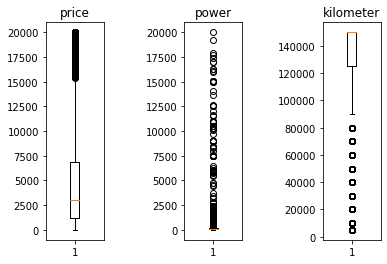

In [20]:
fig = plt.figure()

ax_1 = fig.add_subplot(1, 5, 1)
ax_2 = fig.add_subplot(1, 5, 3)
ax_3 = fig.add_subplot(1, 5, 5)

ax_1.boxplot(df['price']);
ax_1.set_title('price');
ax_2.boxplot(df['power']);
ax_2.set_title('power');
ax_3.boxplot(df['kilometer']);
ax_3.set_title('kilometer');


Все "выбросы" более-менее близки к реальности, поэтому ограничивать параметры мы не будем.

### Добавим новые столбцы

In [21]:
df["weekday"] = df["date_created"].dt.weekday
df["month"] = df["date_created"].dt.month
df["year"] = df["date_created"].dt.year

df.drop('date_created', axis=1, inplace=True)

## Обучение моделей

### Разделение на выборки

#### Label Encoding

In [22]:
categorical = df.select_dtypes(include='object').columns.to_list() + ['weekday', 'month', 'year']

In [23]:
label_encoder = LabelEncoder()

for col in categorical:
    df[col] = label_encoder.fit_transform(df[col])

In [24]:
X_with_cat = df.drop("price", axis=1)
y = df["price"]

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_with_cat, y, test_size=0.2, random_state=421)

#### OHE

In [25]:
df_ohe = pd.get_dummies(df, columns=categorical, drop_first=True)

In [26]:
X_with_cat = df_ohe.drop("price", axis=1)
y = df_ohe["price"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_with_cat, y, 
    test_size=0.2, 
    random_state=42)

### CatBoost

In [28]:
start_time = time.time()
cat = CatBoostRegressor(cat_features=categorical, verbose=10)
params_cat = {
            'learning_rate' : [0.2, 0.16],
            'iterations'    : [150, 100]
                 }
grid_cat = GridSearchCV(estimator=cat, param_grid=params_cat,  scoring='neg_root_mean_squared_error' ,cv=3, n_jobs=-1)
grid_cat.fit(X_train_cat, y_train_cat)
best_1 = -1*grid_cat.best_score_

end_time = time.time() # запоминаем текущее время после выполнения кода
total_time_cat = round(end_time - start_time, 2) # вычисляем время работы кода

print("Время работы кода:", total_time_cat)

0:	learn: 4138.0193631	total: 144ms	remaining: 21.5s
10:	learn: 2813.8487105	total: 817ms	remaining: 10.3s
20:	learn: 2685.1784944	total: 1.42s	remaining: 8.75s
30:	learn: 2631.8303406	total: 2.04s	remaining: 7.85s
40:	learn: 2595.4386168	total: 2.69s	remaining: 7.14s
50:	learn: 2565.0103412	total: 3.31s	remaining: 6.42s
60:	learn: 2542.9521930	total: 3.93s	remaining: 5.74s
70:	learn: 2516.3311600	total: 4.55s	remaining: 5.06s
80:	learn: 2489.2788750	total: 5.17s	remaining: 4.41s
90:	learn: 2471.2300360	total: 5.79s	remaining: 3.75s
100:	learn: 2456.6431523	total: 6.42s	remaining: 3.11s
110:	learn: 2445.8752913	total: 7.04s	remaining: 2.47s
120:	learn: 2433.3813647	total: 7.65s	remaining: 1.83s
130:	learn: 2422.7109502	total: 8.28s	remaining: 1.2s
140:	learn: 2414.4450555	total: 8.89s	remaining: 568ms
149:	learn: 2407.7308521	total: 9.43s	remaining: 0us
0:	learn: 4153.5282968	total: 77.7ms	remaining: 11.6s
10:	learn: 2829.4701144	total: 714ms	remaining: 9.02s
20:	learn: 2690.6891565	to

### LightGBM

In [35]:
X_train_cat_lgb = X_train_cat.copy(deep=True)
X_test_cat_lgb = X_test_cat.copy(deep=True)
y_test_cat_lgb = y_test_cat.copy(deep=True)
for categories in categorical:
    X_train_cat_lgb[categories] = X_train_cat_lgb[categories].astype('category')
    X_test_cat_lgb[categories] = X_test_cat_lgb[categories].astype('category')

In [31]:
start_time = time.time()
model_LGB = LGBMRegressor(random_state=12345, categorical_feature=categorical)

params = {
          'max_depth' : [6, 8]
         }
grid_lgb = GridSearchCV(model_LGB, params, scoring='neg_root_mean_squared_error', cv =3)
grid_lgb.fit(X_train_cat_lgb,y_train_cat)

best_2 = -1*grid_lgb.best_score_

end_time = time.time() # запоминаем текущее время после выполнения кода
total_time_lgb = round(end_time - start_time, 2) # вычисляем время работы кода

print("Время работы кода:", total_time_lgb)

Время работы кода: 44.5


### Random Forest

In [32]:
start_time = time.time()
#через GridSearchCV() найдем лучшие гиперпараметры для модели
parametrs = {'n_estimators': range(1,20,10)}

grid = GridSearchCV(RandomForestRegressor(random_state=42), parametrs, cv=3, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
best_3 = -1*grid.best_score_
end_time = time.time() # запоминаем текущее время после выполнения кода

total_time_for = round(end_time - start_time, 2) # вычисляем время работы кода

print("Время работы кода:", total_time_for)

Время работы кода: 232.38


## Анализ моделей

In [33]:
all_in_one = {
    'model_type' : ['Cat Boost', 'LightGBM', 'Random Forest'],
    'time' : [total_time_cat, total_time_lgb, total_time_for],
    'best_score' : [round(best_1, 2), round(best_2, 2), round(best_3, 2)]}
all_in_one = pd.DataFrame(all_in_one)
all_in_one

,model_type,time,best_score
0,Cat Boost,121.03,2432.57
1,LightGBM,44.50,2354.19
2,Random Forest,232.38,2338.87


Наилучшим образом себя показала модель `LightGBM` -  значение метрики качества меньше 2500 и время обучения наименьшее. Ее и проверим на тесте:

In [37]:
%%time
light_pred = grid_lgb.predict(X_test_cat_lgb)

CPU times: user 640 ms, sys: 0 ns, total: 640 ms
Wall time: 623 ms


In [39]:
print("RMSE на тесте: ", round(mse(y_test_cat_lgb, light_pred)**(.5), 2))

RMSE на тесте:  2346.42


**Вывод:** `LightGBM` больше всего подойдет для опредления стоимости